In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
from pygimli.viewer.mpl import drawStreams
from pygimli.physics import ert

In [20]:
def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    def getABMN(scheme, idx):
        """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
        `scheme`."""
        coords = {}
        for elec in "abmn":
            elec_id = int(scheme(elec)[idx])
            elec_pos = scheme.sensorPosition(elec_id)
            coords[elec] = elec_pos.x(), elec_pos.y()
        return coords
    
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "green"
        else:
            color = "magenta"
        ax.plot(x, y, marker=".", color=color, ms=10)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="center", #fontsize=10, 
                    bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), 
                    xytext=(0, 20), textcoords='offset points', 
                    arrowprops=dict(arrowstyle="wedge, tail_width=.5", fc=color, ec=color,
                                    patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

17/11/22 - 14:51:07 - pyGIMLi - INFO - Cache C:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 5): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\17027409018032572556


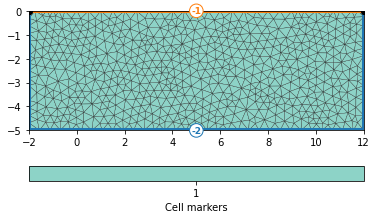

In [21]:
# create data scheme
shm = ert.createData(elecs=11, schemeName="wa")
shm["k"] = ert.createGeometricFactors(shm)
# create world and mesh
world = mt.createWorld(start=[-2, 0], end=[12, -5], worldMarker=True, marker=1)
for pos in shm.sensorPositions():
    world.createNode(pos)

mesh = mt.createMesh(world, area=.1, quality=33, smooth=[1, 10])
pg.show(mesh, markers=True, showMesh=True);

In [22]:
# make a simulation
pot = ert.simulate(mesh=mesh, scheme=shm, res=[[1, 100]], returnFields=1)

In [23]:
print(mesh)
pot.shape

Mesh: Nodes: 652 Cells: 1210 Boundaries: 1861


(11, 652)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x282315970a0>)

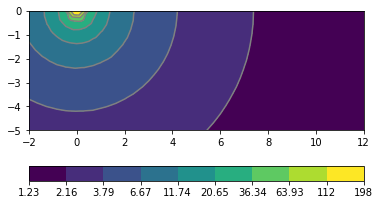

In [24]:
pg.show(mesh, pot[0], logScale=True, nLevs=10)

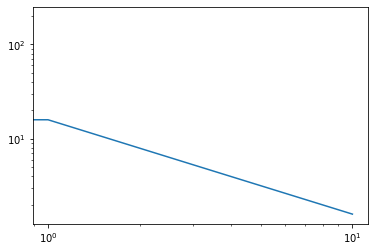

In [25]:
u0 = pg.interpolate(mesh, pot[0], shm.sensorPositions())
pg.plt.loglog(pg.x(shm), u0)

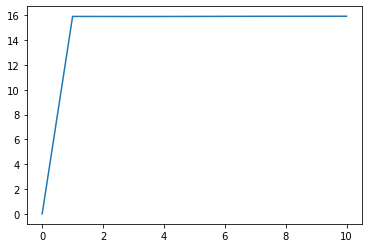

In [53]:
ex = pg.x(shm)
pg.plt.plot(ex, u0*ex)

The product of potential and distance is constant. We remember the formula for the potential
$$u = \frac{I}{2\pi\sigma r} = \frac{\rho I}{2\pi r}$$
If we transform it to the resistivity $\rho$, we obtain
$$\rho = 2\pi r \frac{u}{I} = 2\pi r R = k R$$
The factor $2\pi r$ is referred to as geometric factor and transfers the geometry-dependent resistance $R$ into a specific (geometry-independent) quantity $\rho$.

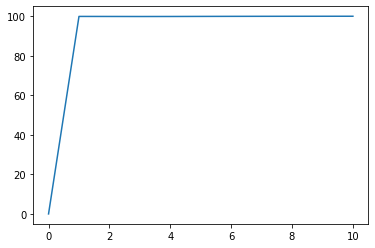

In [54]:
ex = pg.x(shm)
k = 2 * np.pi * ex
pg.plt.plot(ex, u0*k)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x28237710a90>)

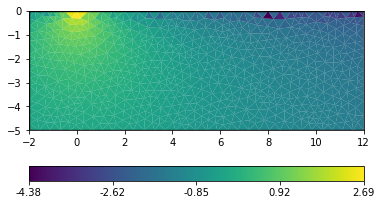

In [51]:
E = -pg.solver.grad(mesh, pot[0])
pg.show(mesh, np.log10(np.abs(E[:, 1])))# pg.core.math.symlog(E[:, 1], 0.1))#, cMin=-1e-4, cMax=1e-4, cMap="bwr")

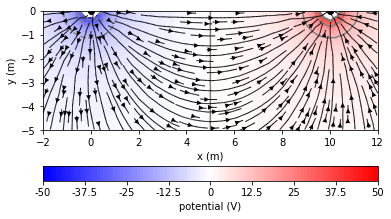

In [26]:
u = pot[10] - pot[0]
cmax = 50
ax, cb = pg.show(mesh, u, cMap="bwr", cMin=-cmax, cMax=cmax, nCols=100,
                 nLevs=9, label="potential (V)")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot([0, 10], [0, 0], "ko");
drawStreams(ax, mesh, u, color='Black');

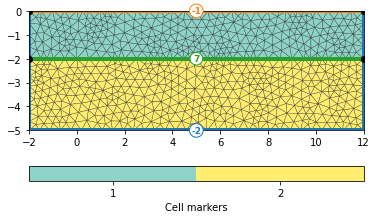

In [57]:
layers = mt.createWorld(start=[-2, 0], end=[12, -5], layers=[-2], worldMarker=True)
for pos in shm.sensorPositions():
    layers.createNode(pos)

mesh = mt.createMesh(layers, area=.1, quality=33, smooth=[1, 10])
pg.show(mesh, markers=True, showMesh=True);

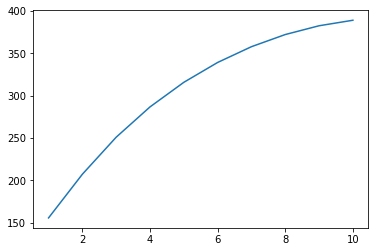

In [62]:
pot = ert.simulate(mesh=mesh, scheme=shm, res=[[1, 100], [2, 1000]], returnFields=1) # 10
ex = pg.x(shm)
u0 = pg.interpolate(mesh, pot[0], shm.sensorPositions())
k = 2 * np.pi * ex
pg.plt.plot(ex[1:], (u0*k)[1:]);

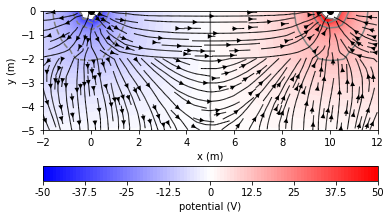

In [63]:
u = pot[10] - pot[0]
cmax = 50
ax, cb = pg.show(mesh, u, cMap="bwr", cMin=-cmax, cMax=cmax, nCols=100,
                 nLevs=9, label="potential (V)")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot([0, 10], [0, 0], "ko");
drawStreams(ax, mesh, u, color='Black');

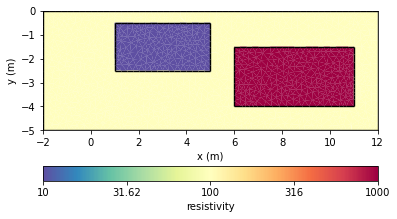

In [27]:
rect = mt.createRectangle(start=[1, -2.5], end=[5, -0.5], marker=2)
rect2 = mt.createRectangle(start=[6, -4], end=[11, -1.5], marker=3)
inhom = world + rect + rect2
mesh2 = mt.createMesh(inhom, area=.05, quality=34, marker=1)
resmap = [[1, 100], [2, 10], [3, 1000]]
ax, _ = pg.show(mesh2, resmap, xlabel="x (m)", ylabel="y (m)",
                label="resistivity", logScale=True, cMap="Spectral_r")

In [28]:
pot2 = ert.simulate(mesh=mesh2, scheme=shm, res=resmap,
                    returnFields=1)

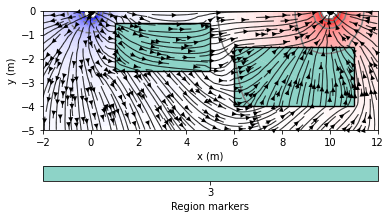

In [29]:
u2 = pot2[10] - pot2[0]
ax, cb = pg.show(mesh2, u2, cMap="bwr", cMin=-cmax, cMax=cmax, nCols=100,
                 nLevs=9, label="potential (V)")
# pg.show(rect, ax=ax, markers=False, colorBar=False)
# %%
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot([0, 10], [0, 0], "ko")
drawStreams(ax, mesh2, u2, color='Black');
pg.show(rect, ax=ax);
pg.show(rect2, ax=ax);

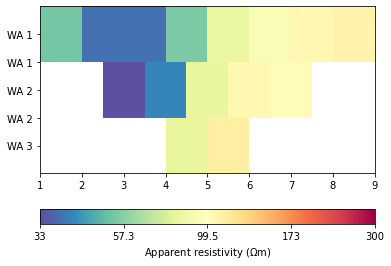

In [10]:
data = ert.simulate(mesh=mesh2, scheme=shm, res=resmap)
ax, _ = pg.show(data, cMin=33, cMax=300);

In [11]:
fop = ert.ERTModelling()
fop.setData(shm)
fop.setMesh(mesh)
model = np.ones(mesh.cellCount())
fop.createJacobian(model)

14/10/22 - 07:34:02 - pyGIMLi - INFO - Found 1 regions.
14/10/22 - 07:34:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
14/10/22 - 07:34:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


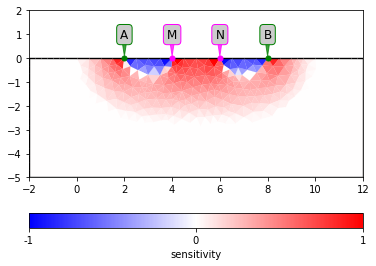

In [12]:
# for i in range(data.size()):
i = 10
sens = fop.jacobian()[i]
normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 1e-2)
normsens /= np.max(normsens)
ax, _ = pg.show(mesh, normsens, cMap="bwr",
                label="sensitivity", nLevs=3, cMin=-1, cMax=1)
plotABMN(ax, shm, i);

14/10/22 - 07:35:42 - pyGIMLi - INFO - Found 2 regions.
14/10/22 - 07:35:42 - pyGIMLi - INFO - Region with smallest marker (1) set to background
14/10/22 - 07:35:42 - pyGIMLi - INFO - Creating forward mesh from region infos.
14/10/22 - 07:35:42 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
14/10/22 - 07:35:42 - pyGIMLi - INFO - Use median(data values)=81.83102491526887
14/10/22 - 07:35:42 - pyGIMLi - INFO - Created startmodel from forward operator: 171 [81.83102491526887,...,81.83102491526887]


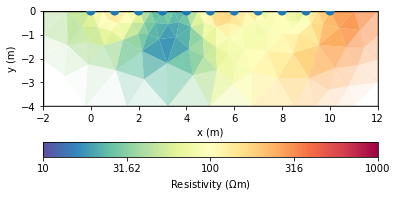

In [15]:
data["err"] = pg.Vector(data.size(), 0.01)
mgr = ert.Manager(data)
mgr.invert()
ax, _ = mgr.showResult(cMin=10, cMax=1000, xlabel="x (m)", ylabel="y (m)",);